# Description

Calculates the Bayesian credibility for the hypothesis that the real single trial success rates of a system A and B are the same up to a given range  `max_allowed_success_rate_difference`, given the number of conducted trials and number of successful tests for both test run A and B.

# Parameters

In [1]:
n_trials_A = 20
n_successes_A = 19

n_trials_B = 20
n_successes_B = 19

max_allowed_success_rate_difference = 0.02

round_to_digits = 4

assert isinstance(n_trials_A, int) and n_trials_A >= 0
assert isinstance(n_trials_B, int) and n_trials_B >= 0
assert isinstance(n_successes_A, int) and 0 <= n_successes_A <= n_trials_A
assert isinstance(n_successes_B, int) and 0 <= n_successes_B <= n_trials_B
assert isinstance(max_allowed_success_rate_difference, float) or isinstance(max_allowed_success_rate_difference, int) and 0 <= max_allowed_success_rate_difference <= 1.0
assert isinstance(round_to_digits, int) and round_to_digits >= 1

# Evaluation

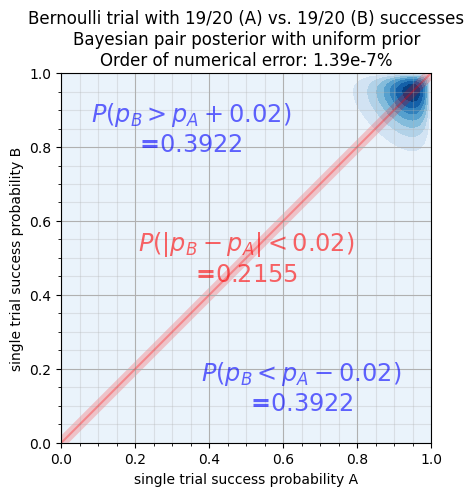

In [2]:
import matplotlib.pyplot as plt
import mpmath as mp
import numpy as np
from scipy import integrate

mp.mp.dps = 50 #use 50 decimal digits precision in mpmath calculations

#posterior is unnormalized to save calculation time, remember to normalize result when needed
def posterior_prob_binom_p(p, n_trials, n_successes, prior):
    return mp.power(mp.mpf(p), n_successes) * mp.power(mp.mpf(1-p), (n_trials-n_successes)) * prior(p)

posterior_prob_binom_p_vectorized = np.vectorize(posterior_prob_binom_p)

def posterior_pairs(p_A, n_trials_A, n_successes_A, prior_A, p_B, n_trials_B, n_successes_B, prior_B):
    return posterior_prob_binom_p_vectorized(p_A, n_trials_A, n_successes_A, prior=prior_A) * posterior_prob_binom_p_vectorized(p_B, n_trials_B, n_successes_B, prior=prior_B)

#split the integral into constant and non-constant parts and prescale so numerical integration does not fail due to sharp peak for large n_trial
def integrate_posterior_prob_binom_p(n_trials, n_successes, prior, bounds):
    mean = (n_successes+1) / (n_trials+2)
    std_dev = ( (n_successes+1)*(n_trials-n_successes+1) / ((n_trials+2)**2*(n_trials+3)) )**0.5
    prescale = 1/posterior_prob_binom_p(mean,n_trials, n_successes, prior)
    prior_prescaled = lambda p: prior(p) * prescale

    if bounds[1] < bounds[0]:
        bounds = [bounds[1], bounds[0]]# bounds[0] must be <= bounds[1]

    bounds = [max(bounds[0], 0), min(1, bounds[1])]
    norm = 0
    if bounds[0] < mean-3*std_dev:
        norm += integrate.quad(posterior_prob_binom_p_vectorized, max(0, bounds[0]), min(mean-3*std_dev, bounds[1]), args=(n_trials, n_successes, prior_prescaled))[0]
    if bounds[0] < mean and bounds[1] >= mean-3*std_dev:
        norm += integrate.quad(posterior_prob_binom_p_vectorized, max(mean-3*std_dev, bounds[0]), min(mean, bounds[1]), args=(n_trials, n_successes, prior_prescaled))[0]
    if bounds[0] < mean+3*std_dev and bounds[1] >= mean:
        norm += integrate.quad(posterior_prob_binom_p_vectorized, max(mean, bounds[0]), min(mean+3*std_dev, bounds[1]), args=(n_trials, n_successes, prior_prescaled))[0]
    if bounds[0] < 1 and bounds[1] >= mean+3*std_dev:
        norm += integrate.quad(posterior_prob_binom_p_vectorized, max(mean+3*std_dev, bounds[0]), min(1, bounds[1]), args=(n_trials, n_successes, prior_prescaled))[0]
        
    return norm / prescale
    
#split the integral into constant and non-constant parts and prescale so numerical integration does not fail due to sharp peak for large n_trial
def integrate_lower_triangle(n_trials_A, n_successes_A, prior_A, n_trials_B, n_successes_B, prior_B, max_allowed_success_rate_difference):
    mean_A = (n_successes_A+1) / (n_trials_A+2)
    mean_B = (n_successes_B+1) / (n_trials_B+2)
    std_dev_A = ( (n_successes_A+1)*(n_trials_A-n_successes_A+1) / ((n_trials_A+2)**2*(n_trials_A+3)) )**0.5
    prescale_A = 1/posterior_prob_binom_p(mean_A, n_trials_A, n_successes_A, prior_A)
    prescale_B = 1/posterior_prob_binom_p(mean_B, n_trials_B, n_successes_B, prior_B)
    prior_prescaled_A = lambda p: prior_A(p) * prescale_A
    prior_prescaled_B = lambda p: prior_B(p) * prescale_B

    bounds = [0, 1]

    f = lambda x: posterior_prob_binom_p(x, n_trials_A, n_successes_A, prior_prescaled_A) * integrate_posterior_prob_binom_p(n_trials_B, n_successes_B, prior_prescaled_B, [0, x-max_allowed_success_rate_difference])
    
    norm = 0
    if bounds[0] < mean_A-3*std_dev_A:
        norm += integrate.quad(f, max(0, bounds[0]), min(mean_A-3*std_dev_A, bounds[1]))[0]
    if bounds[0] < mean_A and bounds[1] >= mean_A-3*std_dev_A:
        norm += integrate.quad(f, max(mean_A-3*std_dev_A, bounds[0]), min(mean_A, bounds[1]))[0]
    if bounds[0] < mean_A+3*std_dev_A and bounds[1] >= mean_A:
        norm += integrate.quad(f, max(mean_A, bounds[0]), min(mean_A+3*std_dev_A, bounds[1]))[0]
    if bounds[0] < 1 and bounds[1] >= mean_A+3*std_dev_A:
        norm += integrate.quad(f, max(mean_A+3*std_dev_A, bounds[0]), min(1, bounds[1]))[0]
        
    return norm / prescale_A / prescale_B

#split the integral into constant and non-constant parts and prescale so numerical integration does not fail due to sharp peak for large n_trial
def integrate_upper_triangle(n_trials_A, n_successes_A, prior_A, n_trials_B, n_successes_B, prior_B, max_allowed_success_rate_difference):
    mean_A = (n_successes_A+1) / (n_trials_A+2)
    mean_B = (n_successes_B+1) / (n_trials_B+2)
    std_dev_A = ( (n_successes_A+1)*(n_trials_A-n_successes_A+1) / ((n_trials_A+2)**2*(n_trials_A+3)) )**0.5
    prescale_A = 1/posterior_prob_binom_p(mean_A, n_trials_A, n_successes_A, prior_A)
    prescale_B = 1/posterior_prob_binom_p(mean_B, n_trials_B, n_successes_B, prior_B)
    prior_prescaled_A = lambda p: prior_A(p) * prescale_A
    prior_prescaled_B = lambda p: prior_B(p) * prescale_B

    bounds = [0, 1]

    f = lambda x: posterior_prob_binom_p(x, n_trials_A, n_successes_A, prior_prescaled_A) * integrate_posterior_prob_binom_p(n_trials_B, n_successes_B, prior_prescaled_B, [x+max_allowed_success_rate_difference, 1.0])
    
    norm = 0
    if bounds[0] < mean_A-3*std_dev_A:
        norm += integrate.quad(f, max(0, bounds[0]), min(mean_A-3*std_dev_A, bounds[1]))[0]
    if bounds[0] < mean_A and bounds[1] >= mean_A-3*std_dev_A:
        norm += integrate.quad(f, max(mean_A-3*std_dev_A, bounds[0]), min(mean_A, bounds[1]))[0]
    if bounds[0] < mean_A+3*std_dev_A and bounds[1] >= mean_A:
        norm += integrate.quad(f, max(mean_A, bounds[0]), min(mean_A+3*std_dev_A, bounds[1]))[0]
    if bounds[0] < 1 and bounds[1] >= mean_A+3*std_dev_A:
        norm += integrate.quad(f, max(mean_A+3*std_dev_A, bounds[0]), min(1, bounds[1]))[0]
        
    return norm / prescale_A / prescale_B

#split the integral into constant and non-constant parts and prescale so numerical integration does not fail due to sharp peak for large n_trial
def integrate_band_around_identity(n_trials_A, n_successes_A, prior_A, n_trials_B, n_successes_B, prior_B, max_allowed_success_rate_difference):
    mean_A = (n_successes_A+1) / (n_trials_A+2)
    mean_B = (n_successes_B+1) / (n_trials_B+2)
    std_dev_A = ( (n_successes_A+1)*(n_trials_A-n_successes_A+1) / ((n_trials_A+2)**2*(n_trials_A+3)) )**0.5
    prescale_A = 1/posterior_prob_binom_p(mean_A, n_trials_A, n_successes_A, prior_A)
    prescale_B = 1/posterior_prob_binom_p(mean_B, n_trials_B, n_successes_B, prior_B)
    prior_prescaled_A = lambda p: prior_A(p) * prescale_A
    prior_prescaled_B = lambda p: prior_B(p) * prescale_B

    bounds = [0, 1]

    f = lambda x: posterior_prob_binom_p(x, n_trials_A, n_successes_A, prior_prescaled_A) * integrate_posterior_prob_binom_p(n_trials_B, n_successes_B, prior_prescaled_B, [x-max_allowed_success_rate_difference, x+max_allowed_success_rate_difference])
    
    norm = 0
    if bounds[0] < mean_A-3*std_dev_A:
        norm += integrate.quad(f, max(0, bounds[0]), min(mean_A-3*std_dev_A, bounds[1]))[0]
    if bounds[0] < mean_A and bounds[1] >= mean_A-3*std_dev_A:
        norm += integrate.quad(f, max(mean_A-3*std_dev_A, bounds[0]), min(mean_A, bounds[1]))[0]
    if bounds[0] < mean_A+3*std_dev_A and bounds[1] >= mean_A:
        norm += integrate.quad(f, max(mean_A, bounds[0]), min(mean_A+3*std_dev_A, bounds[1]))[0]
    if bounds[0] < 1 and bounds[1] >= mean_A+3*std_dev_A:
        norm += integrate.quad(f, max(mean_A+3*std_dev_A, bounds[0]), min(1, bounds[1]))[0]
        
    return norm / prescale_A / prescale_B

p_A = np.linspace(0, 1, 101)
p_B = np.linspace(0, 1, 101)

prior_A = lambda p: 1
prior_B = lambda p: 1

norm_A = integrate_posterior_prob_binom_p(n_trials_A, n_successes_A, prior_A, [0, 1])
norm_B = integrate_posterior_prob_binom_p(n_trials_B, n_successes_B, prior_B, [0, 1])

X, Y = np.meshgrid(p_A, p_B)
posterior_probs = np.array(posterior_pairs(X, n_trials_A, n_successes_A, prior_A, Y, n_trials_B, n_successes_B, prior_B) / (norm_A * norm_B), dtype=float)

P_lower = integrate_lower_triangle(n_trials_A, n_successes_A, prior_A, n_trials_B, n_successes_B, prior_B, max_allowed_success_rate_difference) / (norm_A * norm_B)
P_upper = integrate_upper_triangle(n_trials_A, n_successes_A, prior_A, n_trials_B, n_successes_B, prior_B, max_allowed_success_rate_difference) / (norm_A * norm_B)
P_band_around_identity = integrate_band_around_identity(n_trials_A, n_successes_A, prior_A, n_trials_B, n_successes_B, prior_B, max_allowed_success_rate_difference) / (norm_A * norm_B)
P_sum = P_lower + P_upper + P_band_around_identity
numerical_error_estimate = abs(P_sum - 1)
P_lower_rounded = mp.nstr(mp.mpf(P_lower / P_sum), round_to_digits)
P_upper_rounded = mp.nstr(mp.mpf(P_upper / P_sum), round_to_digits)
P_band_around_identity_rounded = mp.nstr(mp.mpf(P_band_around_identity / P_sum), round_to_digits)

# print(f'{P_lower_rounded=}')
# print(f'{P_upper_rounded=}')
# print(f'{P_band_around_identity_rounded=}')
# print(f'{P_sum=}')

plt.contourf(X, Y, posterior_probs, cmap='Blues')
plt.axline([0,0], [1,1], color='red', alpha=0.3)
plt.fill([0.0, 1.0-max_allowed_success_rate_difference, 1.0, 1.0, max_allowed_success_rate_difference, 0.0], [max_allowed_success_rate_difference, 1.0, 1.0, 1.0-max_allowed_success_rate_difference, 0.0, 0.0], facecolor='red', edgecolor=None, alpha=0.2)
plt.gca().set_title('Bernoulli trial with {}/{} (A) vs. {}/{} (B) successes\nBayesian pair posterior with uniform prior\nOrder of numerical error: {}%'.format(n_successes_A, 
                                                                               n_trials_A, n_successes_B, n_trials_B, mp.nstr(numerical_error_estimate * 100, round_to_digits)))
plt.gca().set_xlabel('single trial success probability A')
plt.gca().set_ylabel('single trial success probability B')
plt.gca().tick_params(axis='x', which='minor', bottom=True)
plt.gca().minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', alpha=0.3);
plt.gca().set_aspect('equal')

plt.text(0.35, 0.85, '$P(p_B > p_A + {})$\n=${}$'.format(max_allowed_success_rate_difference, P_upper_rounded), horizontalalignment='center', verticalalignment='center', fontsize='xx-large', fontweight='bold', alpha=0.6, color='blue')
plt.text(0.5, 0.5, '$P(|p_B - p_A| < {})$\n=${}$'.format(max_allowed_success_rate_difference, P_band_around_identity_rounded), horizontalalignment='center', verticalalignment='center', fontsize='xx-large', fontweight='bold', alpha=0.6, color='red')
plt.text(0.65, 0.15, '$P(p_B < p_A - {})$\n=${}$'.format(max_allowed_success_rate_difference, P_lower_rounded), horizontalalignment='center', verticalalignment='center', fontsize='xx-large', fontweight='bold', alpha=0.6, color='blue');